## Лузина Владимира РИС22-2
# Множественная регрессия

Используя имеющиеся статистические данные выполнить следующие шаги:
1) Используя статистические данные постройте линейную многопараметрическую модель. Постройте диаграмму рассеяния и нанесите на неё линию регрессии.
2) Усложните гипотезу добавив к обоим параметрам аддитивную составляющую в виде функции логарифма по основанию два.

Я не стал удалять выбросы, так как это не связано с задачей семинара

In [302]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy

Исходные данные взяты из варианта 25

In [303]:
df = pd.DataFrame({'day': [i for i in range(1, 21)],  # дни с 1 по 20
                   'price': [1.81, 1.81, 3.78, 3.78, 3.78, 3.78, 3.78, 3.89, 3.93, 3.28, 3.23, 3.21, 3.35, 3.35, 3.37,
                             3.40, 3.25, 3.25, 3.25, 3.29],  # стоимость
                   'amount': [28, 21, 3, 0, 27, 14, 10, 2, 2, 8, 15, 10, 17, 9, 2, 33, 1, 12, 10, 4]})  # число продаж

#df = pd.DataFrame({'day': [i for i in range(1, 21)],  # дни с 1 по 20
#                  'price': [4.1, 4.1, 4.37, 4.37, 4.37, 4.37, 4.37, 4.55, 4.61, 4.39, 4.33, 4.31, 4.49, 4.49, 4.53,
#                            4.57, 4.38, 4.38, 4.38, 4.42],  # стоимость
#                  'amount': [20, 34, 16, 16, 25, 47, 41, 26, 29, 17, 75, 42, 46, 58, 7, 18, 27, 88, 61,31]})  # число продаж
df

,day,price,amount
0,1,1.81,28
1,2,1.81,21
2,3,3.78,3
3,4,3.78,0
4,5,3.78,27
5,6,3.78,14
6,7,3.78,10
7,8,3.89,2
8,9,3.93,2
9,10,3.28,8


### Корреляция

r = correl
$-1 <= r <= 1$

стремится к 1 или -1 хорошо

положительная - при увеличении параметров увеличивается значение
отрицательная - наоборот, с увеличением параметров значения уменьшаются

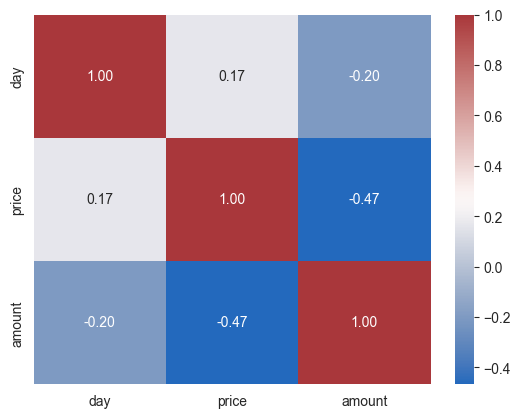

In [304]:
sns.heatmap(df.corr(), cmap="vlag", annot=True, fmt="0.2f");

Из этой таблицы можно увидеть, что количество продаж практически зависит от цены и немного от дня

#### Показатель детерминации
Возведение в квадрат корреляции
показывает на сколько хорошо в долях

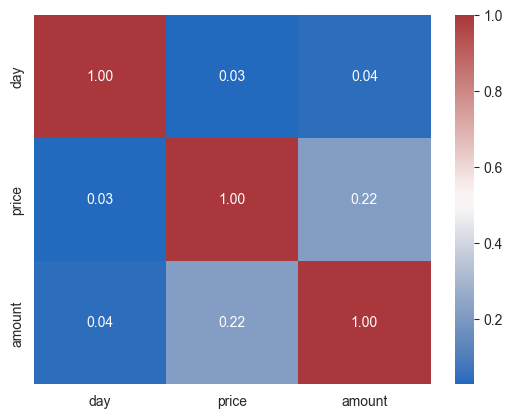

In [305]:
sns.heatmap(df.corr()**2, cmap="vlag", annot=True, fmt="0.2f");

В 22 случаях из 100 параметр цены определяют значение количества продаж, а день вообще не влияет на количество продаж

### Проверка значимости

#### Критерий фишера
Проверка выполнения неравенства
$F_{опытное} > F_{критическое}$

Выполняется -> связь значима
и тогда не важно какая корреляция
Точность прогноза - достаточна
только да или нет

Возьмём альфа значение равное 0.05
(уровень значимости, используемый в статистических тестах, чтобы определить, насколько сильно должны быть различия или корреляции, чтобы считать их статистически значимыми.)

C:\Users\Vladimir Luzin\AppData\Local\Temp\ipykernel_12724\304353711.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  f_op = determ.loc[i, j]/(1-determ.loc[i, j]) * ((n - m - 1) / m)


<Axes: >

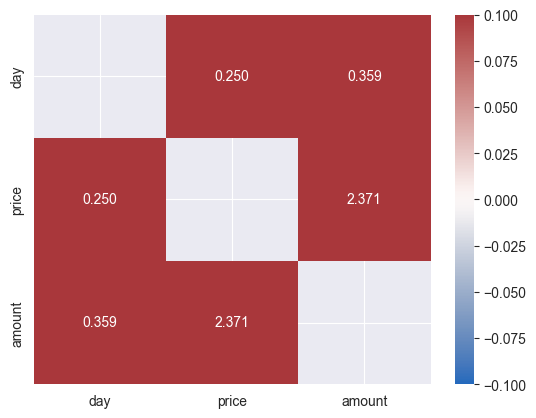

In [306]:
f_ops = pd.DataFrame(index=df.columns, columns=df.columns)
determ = df.corr()**2
m = 2
n = 20
# оп
for i in df.columns:
    for j in df.columns:
        f_op = determ.loc[i, j]/(1-determ.loc[i, j]) * ((n - m - 1) / m)
        f_ops.loc[i, j] = f_op

f_ops = f_ops.astype(float)
sns.heatmap(f_ops, cmap="vlag", annot=True, fmt="0.3f")

In [307]:
# критическое
a = 0.05
m = 2
n = len(df)
critical = scipy.stats.f.ppf(q=1-a, dfn = n, dfd = n-m-1)
critical

2.2303542821753983

Теперь построим таблицу значимости/незначимости критерием

<Axes: >

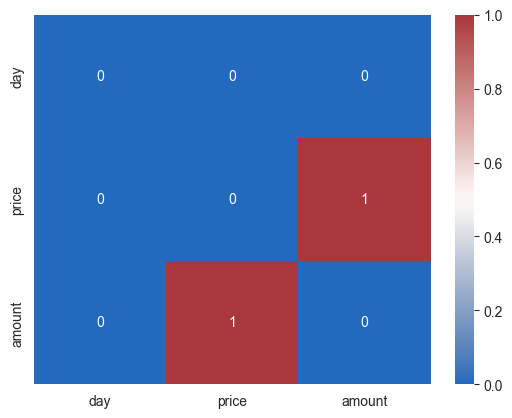

In [308]:
p_values_binary = (f_ops > critical) & (f_ops != float("inf"))
p_values_binary = p_values_binary.astype(int)
sns.heatmap(p_values_binary, cmap="vlag", annot=True, fmt="d")

Здесь 1 - это значащий критерий, а 0 - незначащий
То есть количество продаж зависит от цены и по этому параметру можно попытаться построить модель

В модель включаются факторы, удовлетворяющие следующим условиям:
 1) Факторы должны оказывать значимые воздействия на результат
2) Факторы должны незначимо быть связаны между собой
В данном случае это выполняется только с ценой и строить модель по двум параметрам нет смысла
Наша модель будет являтся статистически не связанной
В учебных целях продолжу исследование

### Линейная многопараметрическая модель

$x_1$ - день торгов
$x_2$ - цена продажи
Регрессионная модель

In [309]:
A =  df.drop("amount", axis=1)
A["A"] = [1 for i in range(len(A))]
temp1 = A["price"]
temp2 = A["day"]
A = A.drop("price", axis=1)
A = A.drop("day", axis=1)
A["day"] = temp2
A["price"] = temp1
A

,A,day,price
0,1,1,1.81
1,1,2,1.81
2,1,3,3.78
3,1,4,3.78
4,1,5,3.78
5,1,6,3.78
6,1,7,3.78
7,1,8,3.89
8,1,9,3.93
9,1,10,3.28


In [310]:
y = df["amount"]
y

0     28
1     21
2      3
3      0
4     27
5     14
6     10
7      2
8      2
9      8
10    15
11    10
12    17
13     9
14     2
15    33
16     1
17    12
18    10
19     4
Name: amount, dtype: int64

Вычислим c

In [311]:
c = (np.linalg.inv(A.T @ A) @ A.T) @ y
c

0    38.386741
1    -0.206134
2    -7.457513
dtype: float64

Окончательно запишем искомую функцию

In [312]:
print(f"f(x) = {c[2]}*x(2) + {c[1]}*x(1) + {c[0]}")

f(x) = -7.457512972713024*x(2) + -0.20613416540563512*x(1) + 38.38674066643448


In [313]:
def linear_regression(x1: float, x2: float) -> float:
    return c[2]*x2 + c[1]*x1 + c[0]

Построим диаграмму рассеяния и нанесем линии регрессии.

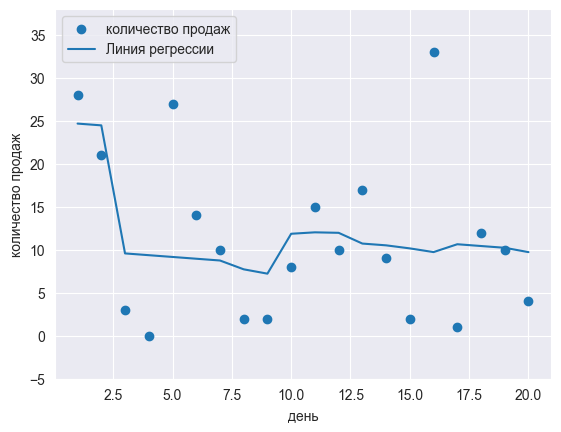

In [314]:
x1_new = np.arange(0, df["day"].max(), 1)
x2_new = np.arange(0, df["day"].max(), 1)
plt.scatter(df["day"], df["amount"], label='количество продаж')
plt.plot(df["day"], linear_regression(df["day"], df["price"]), label='Линия регрессии')
plt.ylim(top=df["amount"].max()+5, bottom=df["amount"].min()-5)
plt.xlabel('день')
plt.ylabel('количество продаж')
plt.legend()
plt.show()

c0 - количество продаж при нулевой цене
c1 - на сколько увеличивается количество продаж с каждым днём
с2 - на сколько увличится/уменьшится количество продаж за единицу цены

Смоделируем получившееся количество продаж

In [315]:
linear_modeled_amounts = pd.DataFrame({'modeled': [linear_regression(i, df[df["day"] == i]["price"].iloc[0]) for i in range(1,21)]})
linear_modeled_amounts

,modeled
0,24.682508
1,24.476374
2,9.578939
3,9.372805
4,9.166671
5,8.960537
6,8.754402
7,7.727942
8,7.223507
9,11.864756


#### Cредняя абсолютная ошибка (англ. Mean Absolute Error, MAE)
Среднеквадратичная ошибка подходит для сравнения двух моделей или для контроля качества во время обучения, но не позволяет сделать выводов о том, на сколько хорошо данная модель решает задачу. Например, MSE = 10 является очень плохим показателем, если целевая переменная принимает значения от 0 до 1, и очень хорошим, если целевая переменная лежит в интервале (10000, 100000).к.

In [316]:
mse = sum([abs(linear_modeled_amounts["modeled"][i] - df["amount"][i]) for i in range(len(df))])/ len(df)
mse

6.150759762492774

В среднем имеет место отклонение на 6 единиц
Учитывая то, что данные имеют разброс от 0 до 33, то это немало

#### Показатель детерминации
Показатель относительного качества модели
То, с какой вероятностью прогноз будет успешен
Коэффициент детерминации (R-squared) указывает на пропорциональный объем изменения в переменной отклика y, объясненный независимыми переменными X в модели линейной регрессии. Чем больше R-squared, тем больше изменчивости объяснено моделью линейной регрессии.

In [317]:
r2 = r2_score(df["amount"], linear_modeled_amounts["modeled"])
r2

0.2335138348334752

Чем ближе значение модели к 1 тем она точнее
В нашем случае точность оставляет желать лучшеного
Только в 23 случаях из 100 на объём продаж влияют день и цена
(квадрат корреляции)

Можно сделать вывод, что модель плохая (так как данные подобраны случайным образом)

### Аддитивная составляющая
В учебных целях усложним гипотезу добавив к обоим параметрам аддитивную составляющую в виде функции логарифма по основанию два

In [318]:
temp = A["price"]
A = A.drop("price", axis=1)
A["day_log"] = np.log2(A["day"])
A["price"] = temp
A["price_log"] = np.log2(A["price"])
A

,A,day,day_log,price,price_log
0,1,1,0.000000,1.81,0.855990
1,1,2,1.000000,1.81,0.855990
2,1,3,1.584963,3.78,1.918386
3,1,4,2.000000,3.78,1.918386
4,1,5,2.321928,3.78,1.918386
5,1,6,2.584963,3.78,1.918386
6,1,7,2.807355,3.78,1.918386
7,1,8,3.000000,3.89,1.959770
8,1,9,3.169925,3.93,1.974529
9,1,10,3.321928,3.28,1.713696


In [319]:
c = (np.linalg.inv(A.T @ A) @ A.T) @ y
c

0    40.499728
1    -0.456517
2     0.947994
3   -16.680612
4    16.584709
dtype: float64

Окончательно запишем искомую функцию

In [320]:
print(f"f(x) = {c[4]}*log(x(2)) + {c[3]}*x(2) + {c[2]}*log(x(1)) + {c[1]}*x(1) + {c[0]}")

f(x) = 16.584709445617214*log(x(2)) + -16.680612237008106*x(2) + 0.9479944819248303*log(x(1)) + -0.456517399781702*x(1) + 40.49972832190883


In [321]:
def log_regression(x1: float, x2: float) -> float:
    return c[4]*math.log2(x2) + c[3]*x2 + c[2]*math.log2(x1) + c[1]*x1 + c[0]

Построим диаграммы рассеяния и нанесем линии регрессии.

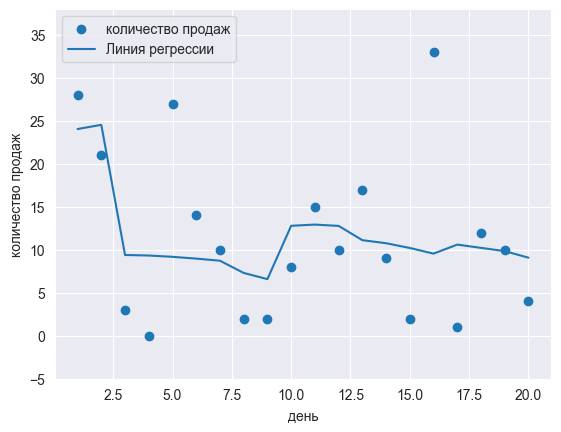

In [322]:
df["predicted_amount"] = df.apply(lambda row: log_regression(row["day"], row["price"]), axis=1)
plt.scatter(df["day"], df["amount"], label='количество продаж')
plt.plot(df["day"], df["predicted_amount"], label='Линия регрессии')
plt.ylim(top=df["amount"].max()+5, bottom=df["amount"].min()-5)
plt.xlabel('день')
plt.ylabel('количество продаж')
plt.legend()
plt.show()

Смоделируем получившееся количество продаж

In [323]:
log_modeled_amounts = pd.DataFrame({'modeled': [log_regression(i, df[df["day"] == i]["price"].iloc[0]) for i in range(1,21)]})
log_modeled_amounts

,modeled
0,24.047643
1,24.539120
2,9.395876
3,9.332812
4,9.181480
5,8.974318
6,8.728628
7,7.306210
8,6.588332
9,12.792463


#### Cредняя абсолютная ошибка (англ. Mean Absolute Error, MAE)

In [324]:
mse = sum([abs(log_modeled_amounts["modeled"][i] - df["amount"][i]) for i in range(len(df))])/ len(df)
mse

6.1394558641024854

В среднем имеет место отклонение на 6 единиц
Учитывая то, что данные имеют разброс от 0 до 33, то это немало

#### Показатель детерминации

In [325]:
r2 = r2_score(df["amount"], linear_modeled_amounts["modeled"])
r2

0.2335138348334752

Чем ближе значение модели к 1 тем она точнее
В нашем случае точность оставляет желать лучшеного
Только в 23 случаях из 100 на объём продаж влияют день и цена
(квадрат корреляции)

Можно сделать вывод, что модель плохая (так как данные подобраны случайным образом)
И усложнение гипотезы не дало результата (так как mae и показатель детерминации практически не поменялись)